# Shapefileとgeotiffファイルを読み込む

## サンプルデータ

下記のサイトからダウンロードできる地球地図を利用している。

https://www.gsi.go.jp/kankyochiri/gm_jpn.html

## shapefile
### shapefileの読み込み
ベクタデータは`geopandas`で`GeoDataFrame`形式で読み込む。  
geopandasの公式ドキュメントはこちら。
https://geopandas.org/

In [1]:
import geopandas as gpd

shapefile_path = '../../data/gsi_go_jp/gm-jpn-all_u_2_2/polbnda_jpn.shp'
admin = gpd.read_file(shapefile_path)
admin

,f_code,coc,nam,laa,pop,ypc,adm_code,salb,soc,geometry
0,FA001,JPN,Hokkai Do,Sapporo Shi,1930496,2014,01100,UNK,JPN,"POLYGON ((141.44980 43.16333, 141.44769 43.157..."
1,FA001,JPN,Hokkai Do,Hakodate Shi,274485,2014,01202,UNK,JPN,"POLYGON ((140.86501 42.01013, 140.86800 42.008..."
2,FA001,JPN,Hokkai Do,Otaru Shi,127224,2014,01203,UNK,JPN,"POLYGON ((141.24820 43.15973, 141.24680 43.158..."
3,FA001,JPN,Hokkai Do,Asahikawa Shi,349057,2014,01204,UNK,JPN,"POLYGON ((142.43280 43.94814, 142.43790 43.944..."
4,FA001,JPN,Hokkai Do,Muroran Shi,91276,2014,01205,UNK,JPN,"POLYGON ((140.99080 42.43800, 140.99680 42.436..."
...,...,...,...,...,...,...,...,...,...,...
2909,FA001,JPN,Tokyo To,UNK,-99999999,0,UNK,UNK,JPN,"POLYGON ((139.80595 35.58558, 139.79480 35.592..."
2910,FA001,JPN,Tokyo To,UNK,-99999999,0,UNK,UNK,JPN,"POLYGON ((140.05172 31.43784, 140.05053 31.437..."
2911,FA001,JPN,Tokyo To,UNK,-99999999,0,UNK,UNK,JPN,"POLYGON ((140.29860 30.47233, 140.28740 30.482..."
2912,FA001,JPN,Tokyo To,UNK,-99999999,0,UNK,UNK,JPN,"POLYGON ((140.34214 29.79279, 140.34153 29.792..."


`GeoDataFrame`の各行にはshapefileの各フィーチャーとそのアトリビュートデータが保存されている。  
jupyter notebook上でプロットするには、`.plot()`を使う。

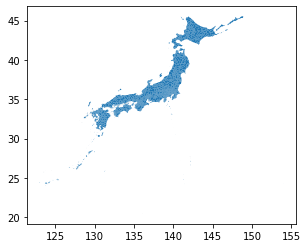

In [2]:
admin.plot()

### 加工
`GeoDataFrame`は`pandas.DataFrame`の拡張のため、`DataFrame`と同じようなテーブル操作が可能。

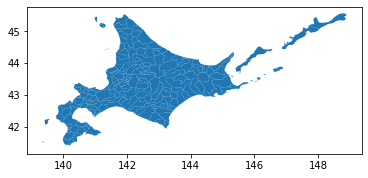

In [3]:
hokkaido = admin[admin.nam == 'Hokkai Do']
hokkaido.plot()

### shapefileへの書き出し
`.to_file()`でファイルを書き出しする。

In [4]:
hokkaido.to_file('../../data/gsi_go_jp/gm-jpn-hokkaido.shp')

## geotiffファイル
ラスタデータは`rasterio`で読み込む。  
rasterioの公式ドキュメントはこちら。  
https://rasterio.readthedocs.io/  
rasterioはピクセルの値をnumpy.array形式で抽出できる。
そのため、下記の流れでデータを処理することが多い。
1. withステイトメントでファイルを開く
2. メタデータ・ピクセル値を抽出
3. numpyで数値計算、統計処理
4. geotiff形式/表形式で出力

### geotiffファイルの読み込み

In [5]:
import rasterio

raster_path = '../../data/gsi_go_jp/gm-jpn-el_u_1_1/jpn/el.tif'
with rasterio.open(raster_path) as raster:
    raster_array = raster.read()
    raster_profile = raster.profile

`raster.read()`で、各バンドのピクセルの値を`numpy.ndarray`形式で取り出せる。

In [6]:
type(raster_array)

numpy.ndarray

In [7]:
raster_array

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [8]:
raster_array.shape

(1, 3600, 4199)

geotiffファイルのメタデータは`raster.profile`でディクショナリ形式で取り出せる。

In [9]:
raster_profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 4199, 'height': 3600, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["unnamed"]'), 'transform': Affine(0.008333333767950535, 0.0, 119.99999898253009,
       0.0, -0.008333333767950535, 50.000000413972884), 'tiled': False, 'interleave': 'band'}

`numpy.ndarray`をjupyter notebook上でプロットするには、`pyplot.imshow()`を使う。

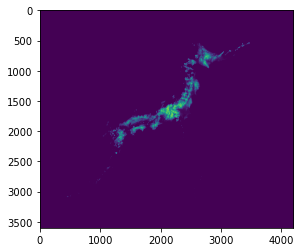

In [10]:
from matplotlib import pyplot

pyplot.imshow(raster_array[0])

`rasterio.plot.show()`を使うと、ラスタの座標系で表示される。

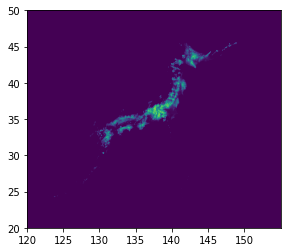

In [11]:
from rasterio.plot import show

with rasterio.open(raster_path) as raster:
    show(raster)

### 加工
ここでは先に作成した`hokkaido`の`GeoDataFrame`の範囲でラスタを切り取る。

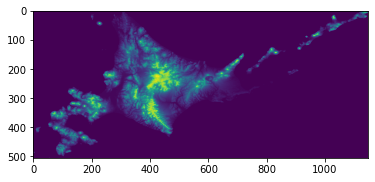

In [12]:
import rasterio.mask

with rasterio.open(raster_path) as raster:
    hokkaido_array, hokkaido_transform = \
        rasterio.mask.mask(dataset=raster,
                           shapes=hokkaido.geometry,
                           crop=True)
    hokkaido_profile = raster.profile

hokkaido_profile.update({'height':hokkaido_array.shape[1],
                         'width':hokkaido_array.shape[2],
                         'transform':hokkaido_transform})
pyplot.imshow(hokkaido_array[0])

### geotiffへの書き出し
`with`ステイトメントで書き込み先を`w`モードで開いてデータを書き込む。

In [13]:
with rasterio.open('../../data/gsi_go_jp/gm-jpn-el_u_1_1/jpn/hokkaido.tif',
                   'w', **hokkaido_profile) as raster:
    raster.write(hokkaido_array)

## Overlay
rasterioの`show()`やgeopandasの`plot()`は、`matplotlib`の図と同様にオーバーレイやスタイルの変更ができる。

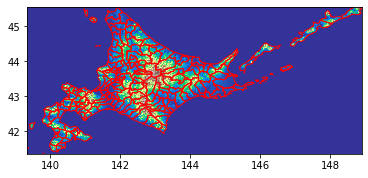

In [14]:
with rasterio.open('../../data/gsi_go_jp/gm-jpn-el_u_1_1/jpn/hokkaido.tif') as raster:
    fig, ax = pyplot.subplots(1)
    show((raster, 1), cmap='terrain', interpolation='none', ax=ax)
    hokkaido.plot(ax=ax, facecolor='none', edgecolor='red')  